# <p style="text-align: right;">Varun Sridhar (vks377)</p>
# <p style="text-align: right;">Atreya Misra (am73676)</p>
# <p style="text-align: center;">EE 461P: Data Science Principles</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 60</p>
## <p style="text-align: center;">Due: Tuesday, October 24th, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1 - Gradient Descent (5+8+2=15pts)

In this question you will implement vanilla SGD and an adaptive gradient update technique called Adagrad. In addition, you will also implement ridge regularization. 

1. Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1*x_1 + w_2*x_1*x_2 + w_3*x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, submit that as a separate file and make a reference to it in your notebook or include the image in your notebook.
2. Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1*x_1 + w_2*x_1*x_2 + w_3*x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'SGD' or 'adagrad' (Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 10 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch count (10 epochs) for the best 2 combinations of learning_rate and regularization for both SGD and Adagrad. ie you should have 2 plots of MSE and parameter updates for SGD and adagrad each. Report the MSE at the end of 10 epochs for all 4 combinations.
3. Based on the experiments, answer the following:

1. Which of the 2 techniqes allows for larger initial setting of the learning_rate? Why?
2. What would a drawback of adagrad be? How could this be fixed? (Hint: Adadelta)

# Notes on Adagrad
Adagrad (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. A cache is maintained that holds the sum of squares of all gradients upto the current update. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = cache + (gradients^2)
2. weights = weights + ((learning_rate)/sqrt(cache+1e-6))*gradients

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

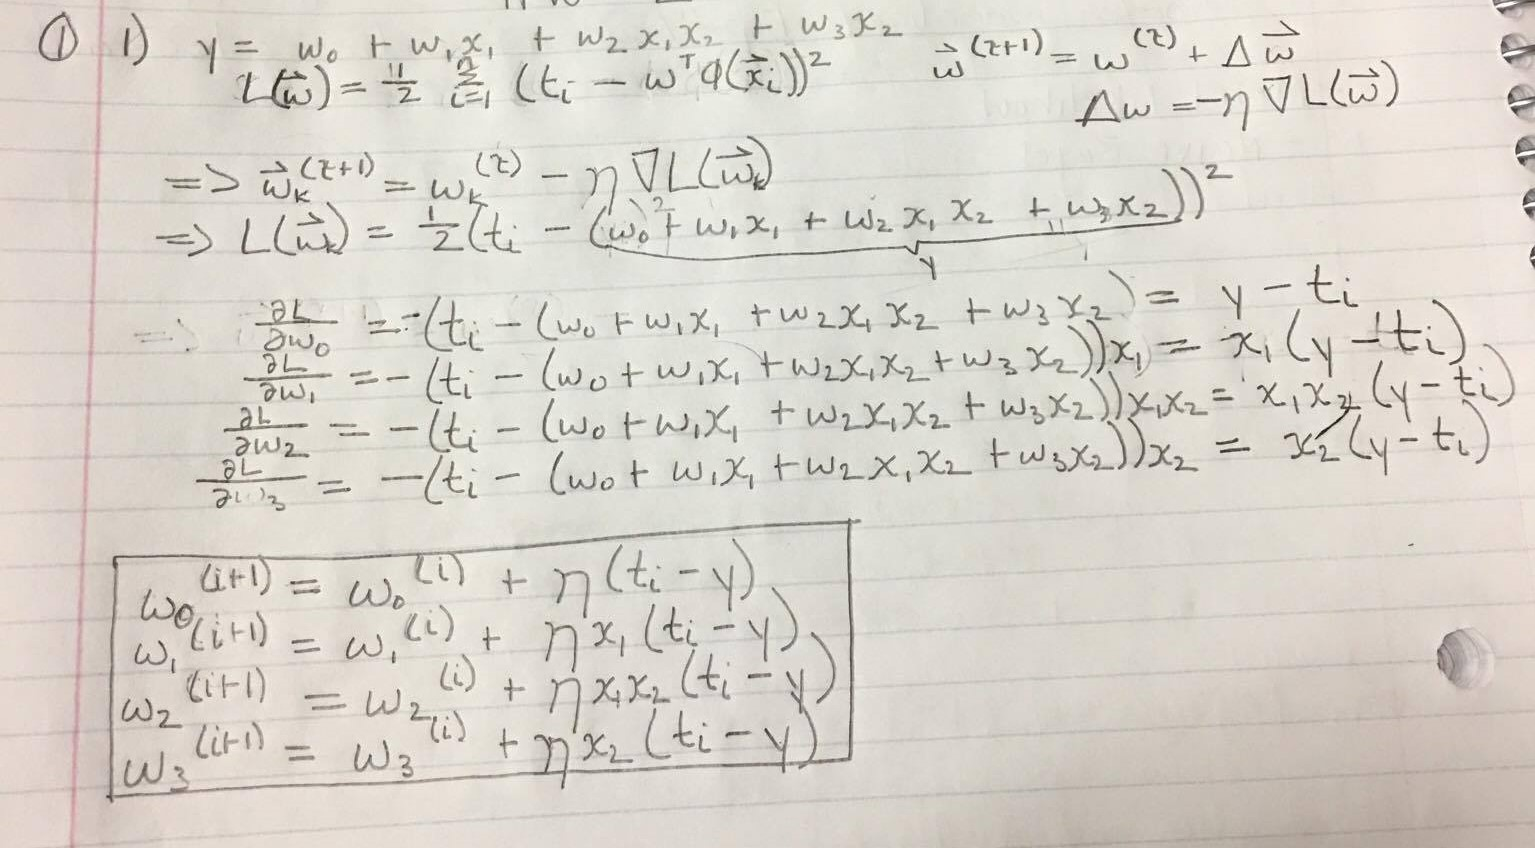

('SGD1 MSE:', 1.0214216038945949e-06)
('SGD2 MSE:', 0.74852414906121101)
('Adagrad1 MSE:', 6.0129480600088073e-21)
('Adagrad2 MSE:', 5.4081694219849106e-20)


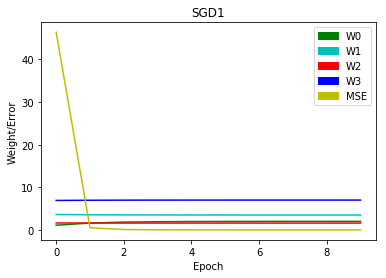

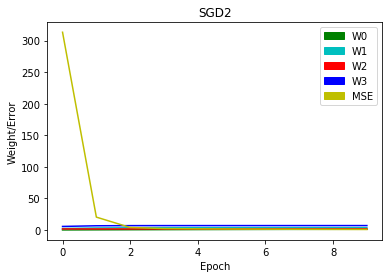

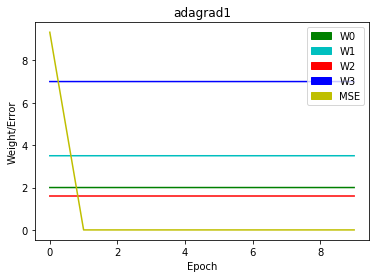

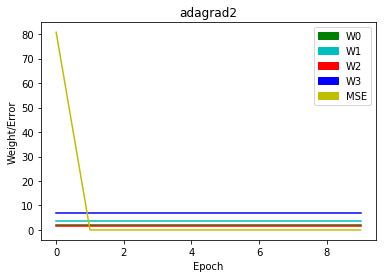

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import datasets
from sklearn.linear_model import Ridge
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

df = pd.read_csv('samples.csv')
X_train, X_test, y_train, y_test = train_test_split(df[['x_1', 'x_2']], df['y'], test_size = 0, random_state = 10)

class SGD:
    def __init__(self, learning_rate, regularization_constant, num_epochs):
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        self.num_epochs = num_epochs
        self.coefs_ = [0, 0, 0, 0]
        self.epochCoefs = []
        self.error = []
        self.finalLoss = 0
        self.mse = []
        
    def fit(self, X, y, update_rule):
        x1 = X["x_1"]
        x2 = X["x_2"]
        x1x2 = x1 * x2
        
        cache = [0, 0, 0, 0]
        for epoch in range(self.num_epochs):
            currentError = 0
            currentMSE = 0
            for i in range(len(x1)):
                X_i = [x1[i], x1x2[i], x2[i]]
                t = y[i] 
                predictY = self.evaluate(self.coefs_, X_i)
                
                currentError = currentError + self.loss(t, predictY, self.coefs_)
                currentMSE = currentMSE + self.MSE(t, predictY)
                grad = self.gradients(X_i, t, predictY, self.coefs_)
                if(update_rule is "adagrad"):
                    cache = self.updateCache(cache, grad)
                self.coefs_ = self.updateWeights(self.coefs_, self.learning_rate, grad, cache, update_rule)
            self.finalLoss = currentError
            self.error.append(currentError)
            self.epochCoefs.append(self.coefs_)
            self.mse.append(currentMSE/1000)
    
    def predict(self, X):
        x1 = X["x_1"]
        x2 = X["x_2"]
        x1x2 = x1 * x2
        y = []
        
        X_predict = [x1, x1x2, x2]
        for i in range(len(X_predict)):
            y[i] = self.evaluate(self.coefs_, X_predict[i])
        return y
        
    
    def evaluate(self, W, X):
        return W[0] + W[1]*X[0] + W[2]*X[1] + W[3]*X[2]
    
    def loss(self, T, Y, W):
        return 0.5 * ((T-Y)**2 + self.regularization_constant * np.linalg.norm(W)**2) 
    
    def MSE(self, T, Y):
        return ((T-Y)**2)
    
    def updateCache(self, cache, G):
        C = []
        C.append(cache[0] + G[0]**2)
        C.append(cache[1] + G[1]**2)
        C.append(cache[2] + G[2]**2)
        C.append(cache[3] + G[3]**2)
        return C
    
    def updateWeights(self, W, learning_rate, G, cache, update_rule):
        weights = []
        if update_rule is "SGD":
            weights.append(W[0] - learning_rate * G[0])
            weights.append(W[1] - learning_rate * G[1])
            weights.append(W[2] - learning_rate * G[2])
            weights.append(W[3] - learning_rate * G[3])
        elif update_rule is "adagrad":
            weightUpdate0 = (learning_rate)/np.sqrt(cache[0] + 1e-6)
            weightUpdate1 = (learning_rate)/np.sqrt(cache[1] + 1e-6)
            weightUpdate2 = (learning_rate)/np.sqrt(cache[2] + 1e-6)
            weightUpdate3 = (learning_rate)/np.sqrt(cache[3] + 1e-6)
            weights.append(W[0] - weightUpdate0*G[0])
            weights.append(W[1] - weightUpdate1*G[1])
            weights.append(W[2] - weightUpdate2*G[2])
            weights.append(W[3] - weightUpdate3*G[3])
        return weights
    
    def gradients(self, X, T, Y, W):
        G = []
        
        G.append(Y - T + self.regularization_constant*W[0])
        G.append(G[0]*X[0] + self.regularization_constant*W[1])
        G.append(G[0]*X[1] + self.regularization_constant*W[2])
        G.append(G[0]*X[2] + self.regularization_constant*W[3])
        
        return G
    
mySGD1 = SGD(0.001, 0, 10)
mySGD1.fit(X_train, y_train, 'SGD')
print("SGD1 MSE:", mySGD1.mse[9])

mySGD2 = SGD(0.0001, 0, 10)
mySGD2.fit(X_train, y_train, 'SGD')
print("SGD2 MSE:", mySGD2.mse[9])

adagrad1 = SGD(1, 0, 10)
adagrad1.fit(X_train, y_train, 'adagrad')
print("Adagrad1 MSE:", adagrad1.mse[9])

adagrad2 = SGD(10, 0, 10)
adagrad2.fit(X_train, y_train, 'adagrad')
print("Adagrad2 MSE:",adagrad2.mse[9])

def graph(regression, title):
    s = np.array(regression.epochCoefs)
    colors = ['g', 'c', 'r', 'b', 'y']
    hndls = []
    for i in range(4):
        plt.plot(s[:,i], color = colors[i])
        patch = mpatches.Patch(color = colors[i], label = "W" + str(i))
        hndls.append(patch)
    patch = mpatches.Patch(color = colors[4], label = str("MSE"))
    hndls.append(patch)
    plt.legend(handles = hndls)
    plt.plot(regression.mse, color = colors[4])
    plt.xlabel("Epoch")
    plt.ylabel("Weight/Error")
    plt.title(title)
    plt.show()

graph(mySGD1, 'SGD1')
graph(mySGD2, 'SGD2')
graph(adagrad1, 'adagrad1')
graph(adagrad2, 'adagrad2')




Adagrad allows for a larger initial setting of the learning_rate.  The learning_rate is eventually minimized in adagrad.  SGD keeps the same learning_rate throughout.

Eventually, in adagrad, the learning rate will decrease to zero, since the stored cache only increases.  One way of fixing this is seen in Adadelta, where the sum of gradients is recursively defined as a decaying average of all past squared gradients.  Older gradients are decayed exponentially more than newer gradient contributions, so recent gradients affect the learning rate more.

# 2. (6+4=10 pts) Tensor Playground
Visit http://playground.tensorflow.org for this problem

A. From the far right, select "Regression" as the problem type, and select the 2nd of the two data sets ( the right one ).  

   i) What sort of test / training loss do you get if you run it for 200 epochs with the following learning rates: .3, .01 and .003 ?  What if you run it for 1000 epochs with these learning rates?  Leave all other values at their defaults ( test/training ratio 50%, Noise 0, Batch Size 10, using Tanh activation function, and No Regularization )
   
   ii) Keeping learning rate at .3, Activation at Tanh, with all others at their defaults, and running for 200 epochs.  
     What sort of test/train loss can you achieve using only 1 neuron in the first hidden layer.  What about for 2,3 or 8 neurons?  Provide screen shots of output layer and comment on how the different output fits look and compare with one another.

   iii)Now keeping learning rate at .03 with all others at their defaults, and running for 200 epochs.  
       Compare how the activation functions affect the ouput ( ReLU, Sigmoid, Tanh, Linear ). Provide screen shots of output results and comment.


B. Neural Nets can fit anything.  Now reset to the initial defaults, and select "Classification" as the problem type, and from the Data section, select the bottom right "Spriral" data set.  With the idea of trying to minimize training/testing error, provide solutions to the problem for the following 2 scenarios.  i) Using just the first 2 inputs ( as per default ) and ii) Using all 7 of the inputs.  You may use as many layers as you want, whatever activation, however man neurons.  Provide screen shots which show your full network, output and parameters. Briefly justify your decisions, and comment on difficulties/tradeoffs, what helps/what doesn't,etc. 

## ANSWER

i). Learning rate = 0.3:
200 epochs: Test loss - 0.013, Training loss - 0.011 || 1000 epochs: Test loss - 0.012, Training loss - 0.011

Learning rate = 0.01:
200 epochs: Test loss - 0.029, Training loss - 0.027 || 1000 epochs: Test loss - 0.018, Training loss - 0.016
    
Learning rate = 0.003: 
200 epochs: Test loss - 0.034, Training loss - 0.032 || 1000 epochs: Test loss - 0.025, Training loss - 0.022




ii). 1 neuron:
Test loss - 0.046, Training loss - 0.045
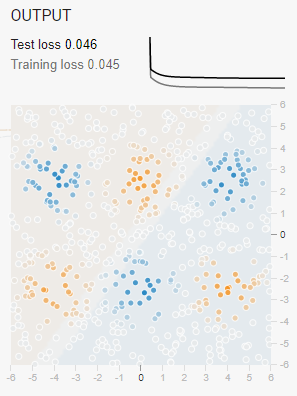
     
2 neurons:
Test loss - 0.033, Training loss - 0.032
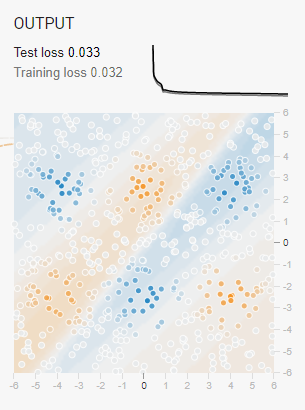

3 neurons:
Test loss - 0.022, Training loss - 0.020
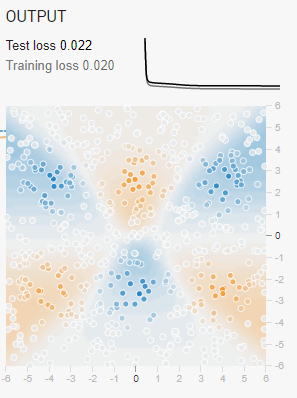

8 neurons:
Test loss - 0.015, Training loss - 0.013
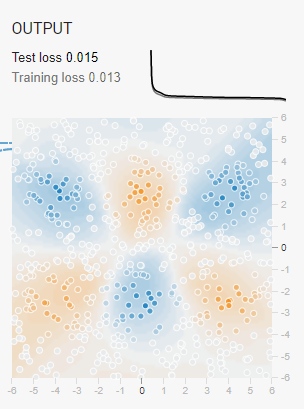

As the number of neurons in the first layer increases, the test loss and training loss decreases.  This shows that the regressor is more accurate with as the number of neurons in the first layer increases.

iii) ReLU: Test loss - 0.031, Training loss - 0.030
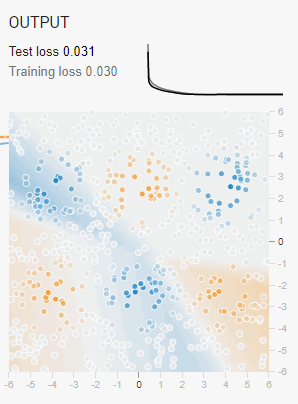

Tanh: Test loss - 0.022, Training loss - 0.018
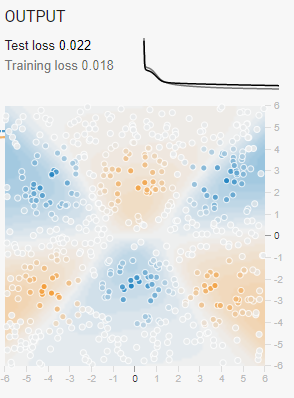

Sigmoid: Test loss - 0.044, Training loss - 0.042
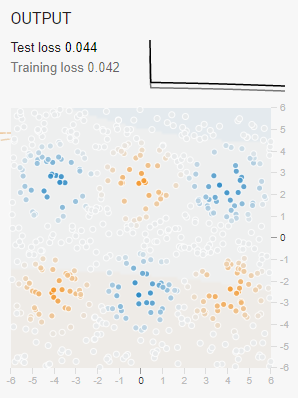

Linear: Test loss - 0.047, Training loss - 0.046
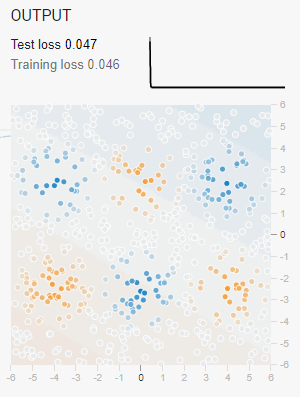

Tanh is most effective, then ReLU, then sigmoid and linear are about equally effective.

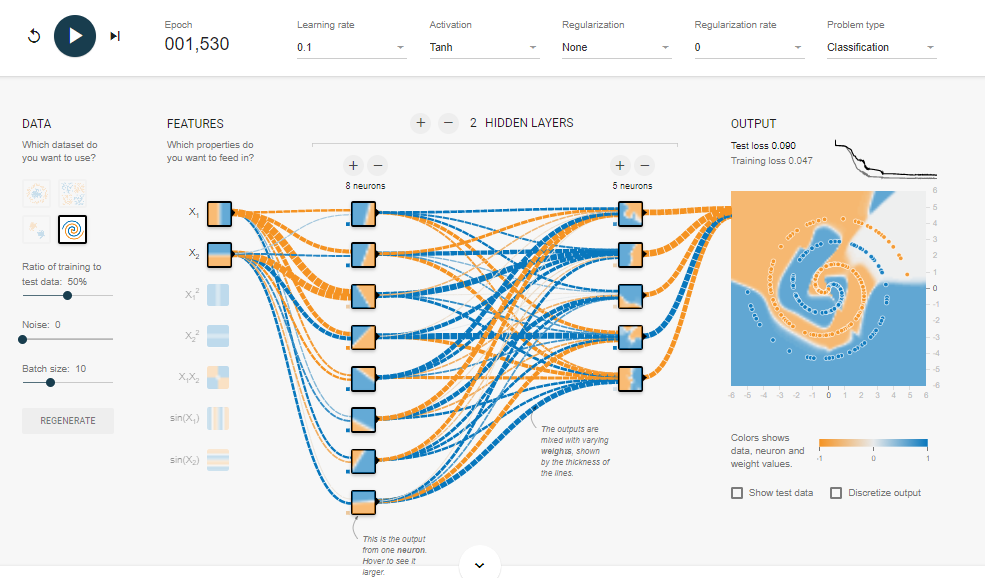
I lowered my learning rate to 0.1 for the most effective solution.  I also used 2 hidden layers with 8 neurons in the first layer and 5 neurons in the second layer.  Lastly, I used a learning rate of 0.1.

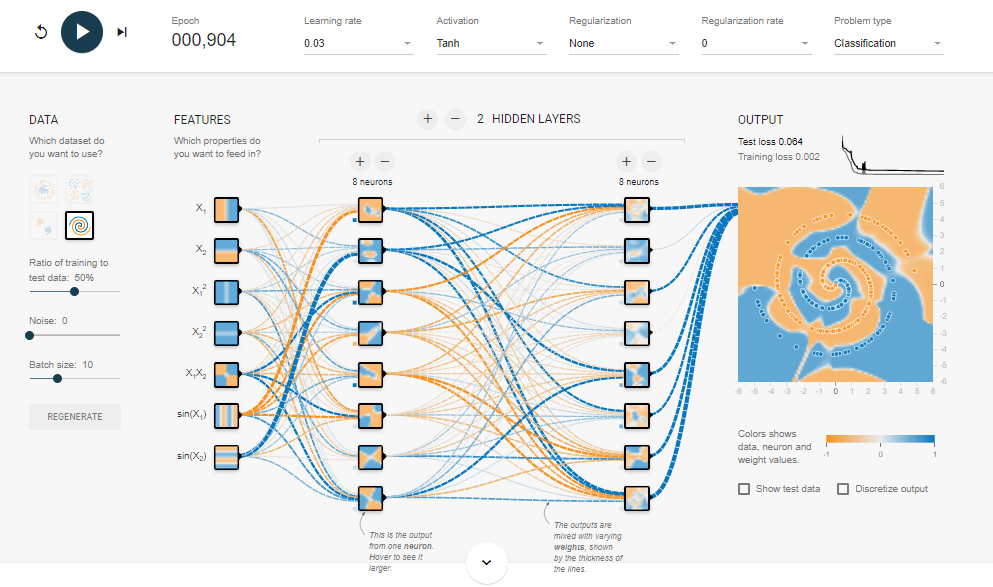
I used the same settings as the previous problem, except I used 8 neurons in the second layer, which allowed for a more complex model to account for more features.

# Question 3: Multi-layer Perceptron Regressor (15 points)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the Appliances energy prediction dataset for this problem https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 42** and **test_size = 0.33**.
Make sure you have 56 variables and one target variable.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

from sklearn import datasets

data = pd.read_csv('./energydata_complete.csv') 

y = data['Appliances']
X = data.drop(['date','Appliances', 'rv1', 'rv2'], axis = 1)


from dateutil import parser
timeData = np.array(data['date'])

days = []
hours = []
for line in range(len(timeData)):
    day = parser.parse(timeData[line]).weekday()
    hour = parser.parse(timeData[line]).hour
    days.append(day)
    hours.append(hour)
    
X = pd.concat([X, pd.get_dummies(days), pd.get_dummies(hours)], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(13222, 56) (13222,) (6513, 56) (6513,)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. 

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, learning_rate_init = 0.005
    
Now, consider three different settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* (b) *hidden_layer_sizes = (6,)* (c) *hidden_layer_sizes = (50,)*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (a), (b), and (c) (5pts)
      
2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best, (a), (b), or (c)? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, hidden_layer_sizes = (50,)
    
Now, consider three different settings for the learning rates:
    
   (i) *learning_rate_init = 0.005* (ii) *learning_rate_init = 0.01* (iii) *learning_rate_init = 1*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (i), (ii), and (iii) (5pts)


## ANSWER

# Question 4: (2+5+3=10 pts) Bayes Decision Theory
a. Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.
( 2 points )

b. Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the customer does not buy a TV and 1 if they do. For each customer, you are given two features, $x_1$ is the per hour salary and $x_2$ is the age. Assume that the class conditional distribution $p([x_1 , x_2]|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 15 and 30 respectively and that of those who don’t is 8.5 and 25. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 3 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem. (5 points)

c. Now sample 100 customers from each class (C = 0, 1) under the assumed distribution and the estimated parameters and plot their features. Additionally, plot the decision boundary you obtained in the part (b) on the same plot. (3 points)

## ANSWER

# Question 5: Decision Tree using Python (10 pts)
In this problem, you will model the data using decision trees to perform a classification task. Load the BreastTissue.csv dataset in the Q1 folder. The dataset has been preprocessed. The description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Tissue). Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree), build two different trees with a maximum depth of two using the split criteria (i) Gini and (ii) Entropy. Use entire data to build trees. Plot the two trees. If your classifier object is called clf, use the following commands to save the generated tree as a '.dot' file that can be used to visualize the tree using Webgraphviz: http://www.webgraphviz.com/

Hint: see  http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

Copy paste the contents of your '.dot' file into the text window on the website to visualize the trees. At which node(s) do they differ?
## ANSWER